In [17]:
# Imports, as always...
from random import choice
from functools import reduce
from tqdm.notebook import tqdm
import numpy as np

from qiskit import execute
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator
from qiskit.quantum_info.states import Statevector
from qiskit.visualization import plot_bloch_multivector

from scripts.dataset import generate_dataset

# Sewing Local Inversions

In this notebook, we implement the method due to Huang et al. (2024) for learning shallow quantum circuits (SQCs) by first finding a set of local inversions $\{V_i\}_{i=1,\dots,n}$ for each qubit $i$ and then "sewing" them together.

Some resources that might be helpful:
- The [original paper](https://arxiv.org/abs/2401.10095), obviously;
- [This tutorial](https://pennylane.ai/qml/demos/tutorial_learningshallow/) "showcasing" the sewing of local inversions as per Huang et al. (2024) with an implementation in PennyLane.

In the following,
- $\text{stab}_1=\{|0\rangle,|1\rangle,|+\rangle,|-\rangle,|y_+\rangle,|y_-\rangle\}$ is the set of single-qubit stabiliser states.

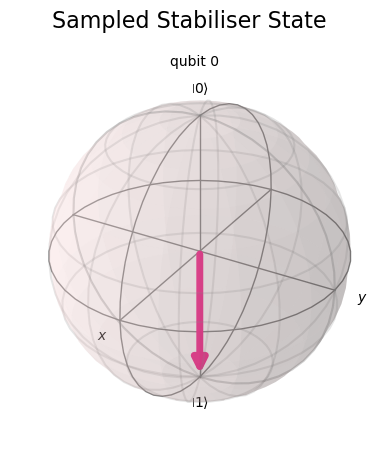

In [2]:
# Function to randomly generate a single-qubit stabiliser state from the above set.
def generate_random_stab_1():
    # List of possible states (by their labelling in Qiskit)
    state_labels = ['0', '1', '+', '-', 'r', 'l']

    # Generate a state vector for a randomly chosen label.
    return Statevector.from_label(choice(state_labels))

# Demo.
random_stab_1 = generate_random_stab_1()
plot_bloch_multivector(random_stab_1, title='Sampled Stabiliser State')

## Generate the SQC $U$

Obviously, we'll need to generate an unknown $n$-qubit unitary $U$ that is "shallow". In the context of this work, "shallow" is taken to mean of a constant depth $\mathcal{O}(1)$.

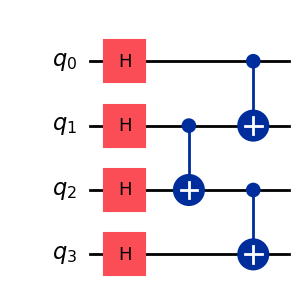

In [2]:
# For now, let's just arbitrarily define a unitary to work with.
# Why not use the one from the tutorial (see resources).
U = QuantumCircuit(4)
U.h(0), U.h(1), U.h(2), U.h(3)
U.cx(1, 2), U.cx(0, 1), U.cx(2, 3)

U.draw('mpl', style='iqp')

## Generating a Dataset

The learning algorithm uses a randomised measurement dataset of size $N$ for the unknown $n$-qubit unitary $U$, which takes the form as given in definition 8:
$$
\mathcal{T}_U(N)=\bigg\{|\psi_\ell\rangle=\bigotimes^n_{i=1}|\psi_{\ell,i}\rangle,|\phi_\ell\rangle=\bigotimes^n_{i=1}|\phi_{\ell,i}\rangle\bigg\}^N_{\ell=1}\ .
$$

Each sample is obtained from one experiment as follows:
1. Sample an input state $|\psi_\ell\rangle=\bigotimes^n_{i=1}|\psi_{\ell,i}\rangle$, which is a product state consisting of uniformly random single-qubit stabiliser states in $\text{stab}_1$.
2. Apply the unknown unitary $U$ to $|\psi_\ell\rangle$.
3. Measure every qubit of $U|\psi_\ell\rangle$ under a random Pauli basis, thus collapsing it to an output state $|\phi_\ell\rangle=\bigotimes^n_{i=1}|\phi_{\ell,i}\rangle$, where $|\phi_{\ell,i}\rangle$ is, again, in $\text{stab}_1$.

After $N$ queries to $U$ in this way, we will have constructed a dataset $\mathcal{T}_U(N)$ with $N$ samples. This is said to be able to be represented efficiently on a classical computer with $\mathcal{O}(Nn)$ bits.

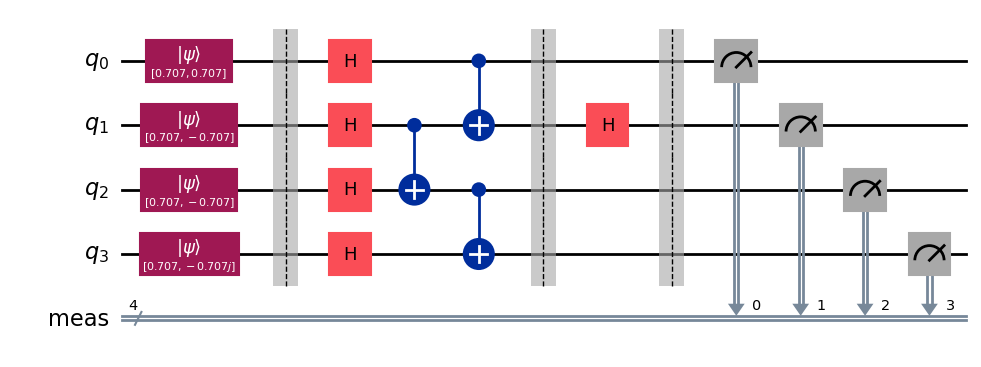

In [4]:
# Function to build a circuit implementing the experiment given in Huang et al. (2024)'s dataset procedure.
def build_experiment_circuit(U):
    # Instantiate a new circuit.
    circuit = QuantumCircuit(U.num_qubits)
    
    # We initialise each of the qubits to specify the input state (as a product of stable states).
    input_states = []
    for i in range(circuit.num_qubits):
        # Choose and keep track of the initialised state.
        init_state = generate_random_stab_1()
        input_states.append(init_state)
        
        # Prepare the qubit.
        circuit.initialize(init_state, i)
        
    # Barrier for clarity.
    circuit.barrier()
        
    # Create a copy of the given unitary so that we may add to the circuit.
    U_copy = U.copy()
    circuit = circuit.compose(U_copy)
    
    # Barrier for clarity.
    circuit.barrier()
    
    # For each qubit, we randomly select a Pauli basis to measure it in (to collapse them to stabiliser states).
    output_bases = []
    for i in range(circuit.num_qubits):
        # Choose a Pauli basis, and keep track of it.
        j = choice([0, 1, 2])
        output_bases.append(j)
        
        # Measuring in the X basis.
        if j == 1:
            circuit.h(i)
            continue
        
        # Measuring in the Y basis.
        elif j == 2:
            circuit.h(i), circuit.sdg(i)
            continue
            
        # Measuring in the Z basis -- no projection needed.
        else:
            continue
        
    # Measure all qubits. A barrier is placed automatically here.
    circuit.measure_all()
    
    # Return the circuit, the input states, and the output bases.
    return circuit, input_states, output_bases

# Demo.
experiment_circuit, input_states, output_bases = build_experiment_circuit(U)
experiment_circuit.draw('mpl', style='iqp')

In [5]:
# Instantiate a backend.
backend = AerSimulator()
job = execute(experiment_circuit, backend=backend, shots=1)
measurement_outcomes = list(job.result().get_counts(experiment_circuit).keys())[0]
measurement_outcomes

'0010'

In [6]:
# Function to translate the measurement outcome to the corresponding output states.
def measurements_to_state_vectors(output_bases, measurement_outcomes):
    # The stabiliser states.
    state_labels = ['0', '1', '+', '-', 'r', 'l']
    
    output_states = []
    for basis, measurement in zip(output_bases, measurement_outcomes):
        # Now our indexing scheme pays off.
        output_states.append(Statevector.from_label(state_labels[2 * basis + int(measurement)]))
        
    return output_states

# Demo.
state_outcomes = measurements_to_state_vectors(output_bases, measurement_outcomes)
state_outcomes

[Statevector([1.+0.j, 0.+0.j],
             dims=(2,)),
 Statevector([0.70710678+0.j, 0.70710678+0.j],
             dims=(2,)),
 Statevector([0.+0.j, 1.+0.j],
             dims=(2,)),
 Statevector([1.+0.j, 0.+0.j],
             dims=(2,))]

In [7]:
# Helper function to combine state vectors into a single product state vector.
def big_tensor(state_vector_list):
    return reduce(lambda x, y : x ^ y, state_vector_list)

# Convert the list of input states and the list of output states into single product states.
input_states = big_tensor(input_states)
state_outcomes = big_tensor(state_outcomes)

input_states, state_outcomes

(Statevector([ 0.25+0.j  ,  0.  -0.25j, -0.25+0.j  ,  0.  +0.25j,
              -0.25+0.j  ,  0.  +0.25j,  0.25+0.j  ,  0.  -0.25j,
               0.25+0.j  ,  0.  -0.25j, -0.25+0.j  ,  0.  +0.25j,
              -0.25+0.j  ,  0.  +0.25j,  0.25+0.j  ,  0.  -0.25j],
             dims=(2, 2, 2, 2)),
 Statevector([0.        +0.j, 0.        +0.j, 0.70710678+0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.70710678+0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j],
             dims=(2, 2, 2, 2)))

In [9]:
# The full dataset generation procedure.
def generate_dataset(U, N):
    # Instantiate a backend simulator and dataset list.
    backend = AerSimulator()
    dataset = []
    
    # Running the experiment N times to produce a dataset of N pairs.
    for _ in tqdm(range(N), desc='Generating dataset'):
        # Set up the experiment.
        circuit, input_states, output_bases = build_experiment_circuit(U)
        
        # Execute the circuit (once) and note the measurement outcome string.
        job = execute(circuit, backend=backend, shots=1)
        measurement_outcomes = list(job.result().get_counts(circuit).keys())[0]  
        
        # Translate the measurement outcome string to the corresponding state vector.
        state_outcomes = measurements_to_state_vectors(output_bases, measurement_outcomes)
        
        # Covert the state lists into product states.
        input_states = big_tensor(input_states)
        state_outcomes = big_tensor(state_outcomes)
        
        # Append to the dataset.
        dataset.append((input_states, state_outcomes))
        
    return dataset

In [3]:
# Generating a dataset.
dataset = generate_dataset(U, N=10)

Generating dataset:   0%|          | 0/10 [00:00<?, ?it/s]

Lemma 12 shows how we can reuse the randomised measurement dataset $\mathcal{T}_U(N)$ to create the datasets needed to learn approximate Heisenberg-evolved Pauli observables: we can create $3n$ datasets $\mathcal{T}_{U^\dag P_iU}(N)$, for each Pauli observable $P\in\{X,Y,Z\}$ and each qubit $i$,
$$
\mathcal{T}_{U^\dag P_iU}(N):=\Bigg\{|\psi_\ell\rangle=\bigotimes_{j=1}^n|\psi_{\ell,j}\rangle,v_\ell^{U^\dag P_iU}\Bigg\}^N_{\ell=1}\ ,
$$
where $|\psi_{\ell,i}\rangle$ is sampled uniformly and independently from $\text{stab}_1$, and $v_\ell^{U^\dag P_iU}$ with $\mathbb{E}[v_\ell^{U^\dag P_iU}]=\langle\psi_\ell|U^\dag P_iU|\psi_\ell\rangle$ and $|v_\ell^{U^\dag P_iU}|=\mathcal{O}(1)$.

## Finding Local Inversion Unitaries

By definition 12, $V_i$ is a strong $\varepsilon$-approximate local inversion of $U$ on the $i$-th qubit if $\mathcal{UV}_i$ is a strong $\varepsilon$-approximate local identity on the $i$-th qubit.

We may consider corollary 2, stating that if $V_i$ satisfies
$$
\sum_{P\in\{X,Y,Z\}}\Big\|V_i^\dag U^\dag P_iUV_i-P_i\Big\|_\infty\leq\varepsilon\ ,
$$
where $P_i$ acts with $P$ on the $i$-th qubit and $I$ on the others, then $V_i$ is a strong $\varepsilon$-approximate local inversion of $U$ on the $i$-th qubit.

The idea is to learn $n$ local inversion unitaries $V_1,\dots,V_n$ instead of the entire $n$-qubit unitary at once. The most straightfoward way to do this, following corollary 2, is to first learn the Heisenberg-evolved single-qubit Pauli observable $U^\dag P_iU$ for all $P_i$, then try to find the $V_i$ that evolves it approximately back to $P_i$. This is the simplest approach computationally, but is said to yield higher depth in the learnt circuit.

By definition 14, an $n$-qubit observable $O_{i,P}$ is an $\varepsilon$-approximate Heisenberg-evolved Pauli observable $P$ on qubit $i$ under $U$ if $\|O_{i,P}-U^\dag P_iU\|_\infty\leq\varepsilon$.

### A loss function for local inversion

To start with, we want to locally invert in the same way as Huang et al. (2024) -- by finding an inversion unitary for a single qubit. Let the found local inversion be $V_i$. The quality of the found $V_i$ depends on how close to zero we can get the equation from corollary 2 (above), and as soon as we have at most $\varepsilon$, we can be happy to move on to finding the next one. 

In [14]:
i, n = 4, 10
"I" * (i - 1) + "X" + "I" * (n - i)

'IIIXIIIIII'

In [42]:
# Function to verify whether a given unitary V_i is a local inversion of another given unitary U.
def verify_local_inversion(V_i : np.matrix, i, U : np.matrix, eps : float = 1e-3):
    # We assume V_i and U are numpy matrices (for the sake of a clean implementation; presumably there is also a Qiskit way).
    
    # Compute the adjoints of V_i and U.
    V_i_dag = V_i.getH()
    U_dag = U.getH()
    
    # Defining circuits for the Pauli operators.
    qc_x = QuantumCircuit(U.shape[0])
    qc_x.x(i)
    qc_y = QuantumCircuit(U.shape[0])
    qc_y.y(i)
    qc_z = QuantumCircuit(U.shape[0])
    qc_z.z(i)
    
    # List of Pauli matrices applied only on the i-th qubit.
    paulis = [np.matrix(Operator(qc_x).data), np.matrix(Operator(qc_y).data), np.matrix(Operator(qc_z).data)]
    
    # Using corollary 2 from Huang et al. (2024).
    return np.sum([
        np.linalg.norm(reduce(np.matmul, [V_i_dag, U_dag, paulis[j], U, V_i]) - paulis[j], ord=np.inf)
        for j in range(3)
    ])# <= eps

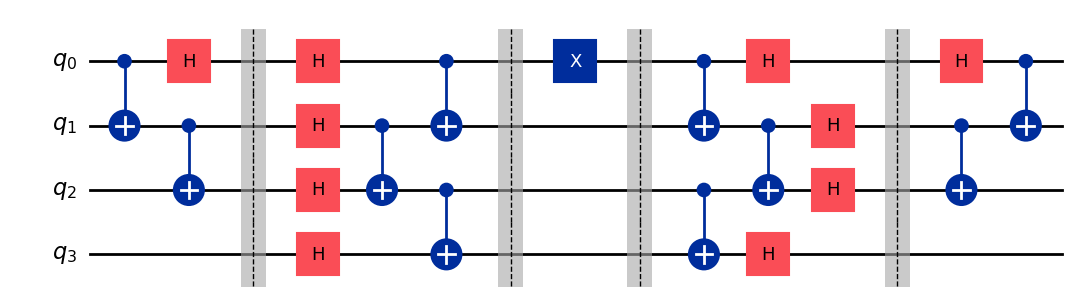

In [55]:
# Demo.

# Create a master circuit to implement the left-hand part of the difference in the norm of corollary 2. 
master_circuit = QuantumCircuit(4)

# Pauli X on i-th qubit. We would also do Y and Z.
i = 0
qc_x = QuantumCircuit(4)
qc_x.x(i)

# We can easily see the true local inversion of the i-th qubit.
true_V_0 = QuantumCircuit(4)
true_V_0.cx(0, 1)
true_V_0.cx(1, 2)
true_V_0.h(0)

# Compose the master circuit from the smaller circuits.
master_circuit = master_circuit.compose(true_V_0)
master_circuit.barrier()
master_circuit = master_circuit.compose(U)
master_circuit.barrier()
master_circuit = master_circuit.compose(qc_x)
master_circuit.barrier()
master_circuit = master_circuit.compose(U.inverse())
master_circuit.barrier()
master_circuit = master_circuit.compose(true_V_0.inverse())

master_circuit.draw('mpl', style='iqp')

## Sewing the Local Inversions

By definition 13, given the local inversions $V_1,\dots,V_n$, the sewed $2n$-qubit unitary consisting of two sets of $n$ qubits is given by
$$
U_\text{sew}(V_1,\dots,V_n):=S\Bigg[\prod_{i=1}^n\Big(V_i^{(1)}\Big)S_i\Big(V_i^{(1)}\Big)^\dag\Bigg]\ ,
$$
where $V_i^{(1)}$ corresponds to applying the $n$-qubit unitary $V_i$ on the first $n$ qubits, $S_i$ is the swap operator for the $i$-th qubit between the two sets of $n$ qubits, and $S$ is the swap operator for all $2n$ qubits. The specific sewing order does not matter, except with regard to optimisation.

Alternatively, by definition 15, given a set of $3n$ Heisenberg-evolved Pauli observables $O_{i,P}$ for all $i\in\{1,\dots,n\}$ and $P\in\{X,Y,Z\}$, then the sewed $2n$-qubit unitary is given by
$$
U_\text{sew}(\{O_{i,P}\}_{i,P}):=S\prod_{i=1}^n\Bigg[\text{Proj}_U\Bigg(\frac{1}{2}I\otimes I+\frac{1}{2}\sum_{P\in\{X,Y,Z\}}O_{i,P}\otimes P_i\Bigg)\Bigg]\ ,
$$
where $\text{Proj}_U(A)$ is the projection of a matrix $A$ to a unitary matrix minimising the operator norm $\|\cdot\|_\infty$; i.e. $\text{Proj}_U(A):=\text{argmin}_{B:\text{unitary}}\|A-B\|_\infty$.